# Language Models are Few-Shot Learners


---


Цель исследования: может ли масштабирование языковых моделей (увеличение размера и данных) привести к универсальным системам, способным адаптироваться к новым задачам без обновления параметров.

В данной статье иллюстрировалось, как модель GPT-3 может эффективно учиться через контекстные примеры(in-context learning). Для этого не нужно собирать датасеты для дообучения.




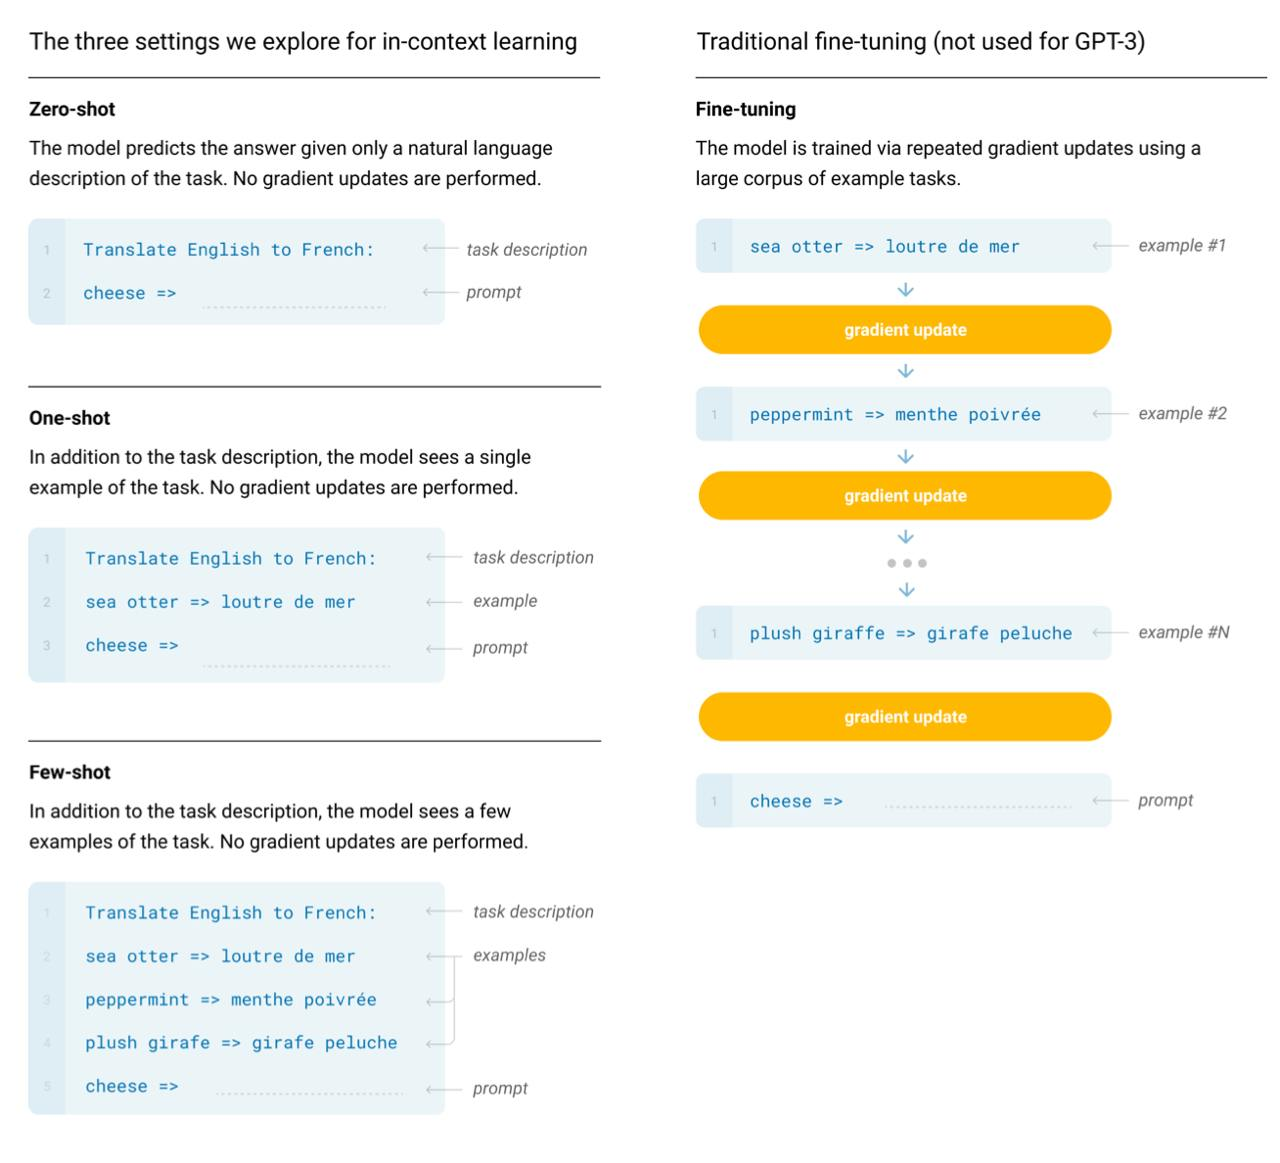

Некоторые примеры использования GPT-3.

1) LAMBADA(LAnguage Modeling for Broadened Domains and Architectures): тестирует способность модели обрабатывать долгосрочные зависимости в тексте — модель должна предсказать последнее слово предложений, для понимания которых требуется прочтение целого абзаца контекста.

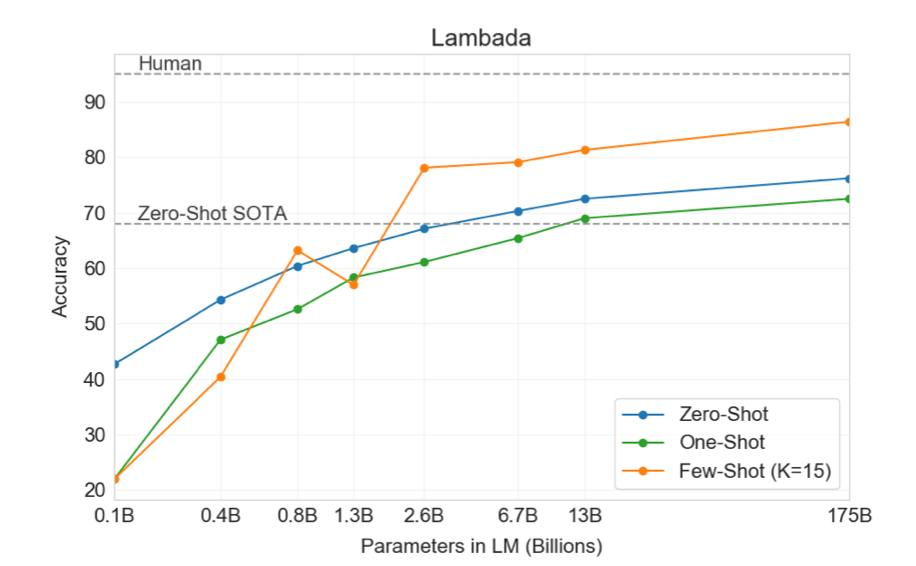

2) Перевод

3) Арифметика

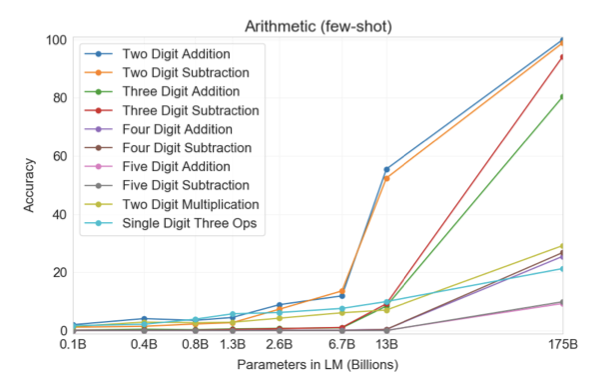

4) NLI(Natural Language Inference): определение логической связи между предложениями.
Пример: "Определите логическую связь между предложениями:  
1. Посылка: 'Кошка сидит на ковре'. Гипотеза: 'На ковре находится животное'. Ответ: следование.  
2. Посылка: 'Дверь открыта'. Гипотеза: 'Дверь закрыта'. Ответ: противоречие.  
3. Посылка: 'В комнате горит свет'. Гипотеза: 'В комнате темно'. Ответ: ?"

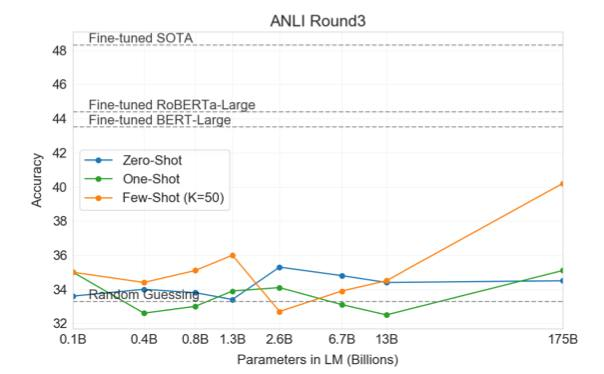

5) Генерация новостных статей

# Результаты
1) Рост качества с увеличением размера модели

2) На многих датасетах GPT-3 в few-shot (10–100 примеров) сопоставима с fine-tuned моделями. Она решает различные задачи на понимание текста, генерацию текста, простая арифметика и т.д.

3) Few-shot позволяет решать новые задачи без переобучения, используя только примеры в промпте.

4) Недостатки:

 не справляется с многошаговыми арифметическими вычислениями;

 путается в задачах, требующих последовательных рассуждений;

 путается в "смешанных" задачах("Было 12 яблок. 2 яблока выкинули и 2 съели. Сколько осталось яблок?");

 не решает задачи, требующие точной работы с символами(циклический сдвиг букв,анаграмма (кроме первой и последней буквы), случайные вставки символов);

# Задание

Провести сравнение техник Zero-Shot, One-Shot, Few-Shot для одной и той же модели на некотором количестве текстовых задач (логика, математика, рассуждения, любая специфическая область).
Построить сравнение этих техник и выявить наиболее эффективную, провести
экономическое сравнение с измерением числа потраченных на генерацию одного ответа токенов включая промпт.

In [ ]:
# !pip uninstall torch
# !pip install torch
!pip install -q gradio_client tiktoken matplotlib pandas transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.6 MB/s eta 0:00:00


In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
# Client — класс для взаимодействия с развёрнутыми Gradio-приложениями. Позволяет отправлять данные в модель через API и получать предсказания.
from gradio_client import Client
# Библиотека от OpenAI для подсчёта токенов в тексте.
import tiktoken
from transformers import Qwen2Tokenizer

In [ ]:
client = Client("Qwen/Qwen2.5")

# Используем токенизатор
tokenizer = Qwen2Tokenizer.from_pretrained("Qwen/Qwen-tokenizer")

# Текстовые задачи: математика, логика, размышления, медицина, законы, перевод
TASKS = {
    "math": {
        "question": "Дай ответ: cколько будет 73 плюс 49?",
        "one_shot_example": "Сколько будет 12 плюс 9? Ответ: 21",
        "few_shot_examples": [
            "Сколько будет 52 плюс 8? Ответ: 60",
            "Сколько будет 41 плюс 11? Ответ: 52",
            "Сколько будет 91 плюс 2? Ответ: 93"
        ]
    },
    "logic": {
        "question": "Если все люди — млекопитающие, а некоторые млекопитающие — врачи, можно ли сказать, что некоторые люди — врачи?",
        "one_shot_example": "Если все кошки — животные, а некоторые животные — пушистые, можно ли сказать, что некоторые кошки — пушистые? Ответ: возможно",
        "few_shot_examples": [
            "Если все птицы летают, а некоторые животные — птицы, можно ли сказать, что некоторые животные летают? Ответ: да",
            "Если все рыбы плавают, а некоторые рыбы — быстрые, можно ли сказать, что некоторые существа — быстрые? Ответ: да",
            "Если все деревья зелёные, а некоторые зелёные объекты — яблоки, можно ли сказать, что все деревья — яблоки? Ответ: нет"
        ]
    },
    "reasoning": {
        "question": "Как можно использовать ложку, кроме как для еды?",
        "one_shot_example": "Как можно использовать газету, кроме как для чтения? Ответ: использовать как упаковку",
        "few_shot_examples": [
            "Как можно использовать коробку, кроме хранения вещей? Ответ: использовать как табуретку",
            "Как можно использовать старый CD-диск? Ответ: сделать подставку",
            "Как можно использовать бутылку? Ответ: как вазу"
        ]
    },
    "medical": {
        "question": "Каковы возможные причины головной боли у взрослого человека?",
        "one_shot_example": "Каковы возможные причины кашля у ребёнка? Ответ: простуда, инфекция, аллергия, астма",
        "few_shot_examples": [
            "Каковы возможные причины боли в животе? Ответ: гастрит, аппендицит, отравление, несварение",
            "Каковы возможные причины повышения температуры тела? Ответ: инфекция, травма, воспаление, перегрев",
            "Каковы возможные причины сыпи на коже? Ответ: аллергия, ветряная оспа, инфекция, дерматит"
        ]
    },
    "legal": {
        "question": "Можно ли уволить сотрудника без объяснения причин?",
        "one_shot_example": "Можно ли расторгнуть договор аренды досрочно? Ответ: да, при наличии соответствующего условия в договоре",
        "few_shot_examples": [
            "Можно ли продать квартиру без согласия супруга? Ответ: нет, если имущество совместное",
            "Можно ли обжаловать штраф ГИБДД? Ответ: да, в течение 10 дней",
            "Можно ли заключить трудовой договор с несовершеннолетним? Ответ: да, при соблюдении определённых условий"
        ]
    },
    "translation": {
        "question": "Переведи на английский: Была хорошая погода с утра.",
        "one_shot_example": "Переведи на английский: Она пошла в магазин. Ответ: She went to the store.",
        "few_shot_examples": [
            "Переведи на английский: Он играет на гитаре. Ответ: He plays the guitar.",
            "Переведи на английский: Мы живём в большом городе. Ответ: We live in a big city.",
            "Переведи на английский: Я устала. Ответ: I am tired."
        ]
    },
    "nli": {
        "question": "Текст 1: Все студенты сдали экзамен. Текст 2: Некоторые студенты провалили экзамен. Вопрос: Противоречат ли эти утверждения друг другу?",
        "one_shot_example": "Текст 1: Джон любит мороженое. Текст 2: Джон ненавидит мороженое. Вопрос: Противоречат ли эти утверждения друг другу? Ответ: да",
        "few_shot_examples": [
            "Текст 1: Анна пошла в кино. Текст 2: Анна осталась дома. Вопрос: Противоречат ли эти утверждения друг другу? Ответ: да",
            "Текст 1: Некоторые люди любят спорт. Текст 2: Не все люди любят спорт. Вопрос: Противоречат ли эти утверждения друг другу? Ответ: нет",
            "Текст 1: Вчера шёл дождь. Текст 2: Вчера не было дождя. Вопрос: Противоречат ли эти утверждения друг другу? Ответ: да"
        ]
    }
}

# def evaluate(task_name, prompt, tokenizer, client):
#     def count_tokens(text):
#         print(text)
#         ret = tokenizer.encode(text)
#         print(len(ret))

#         return len(ret)

#     start = time.time()
#     response = client.predict(
#       query=prompt,
#       history=[],
#       system="You are Qwen, created by Alibaba Cloud. You are a helpful assistant.",
#       radio="72B",
#       api_name="/model_chat"
#     )
#     end = time.time()

#     response_str = response[1][0][1]['text']
#     print("----------------------------------------------")

#     print(f"Вопрос: {prompt}")
#     print(f"Ответ: {response_str}\n\n")

#     # Ensure the response is a string
#     response_str = str(response_str)

#     print("*********************************************")

#     print("promt_tokens:\n")
#     prompt_tokens = count_tokens(prompt)
#     print("\nresponse_tokens:\n")
#     response_tokens = count_tokens(response_str)
#     print("\n\n")

#     print("---------------------------------------------")

#     return {
#         "task": task_name,
#         "prompt": prompt,
#         "response": response_str,
#         "prompt_tokens": prompt_tokens,
#         "response_tokens": response_tokens,
#         "total_tokens": prompt_tokens + response_tokens,
#         "time": end - start
#     }

def evaluate(task_name, prompt, tokenizer, client):
    def count_tokens(text):
        ret = tokenizer.encode(text)
        return len(ret)

    start = time.time()
    prompt_tokens = 0
    response_tokens = 0
    for i in range(5):
      response = client.predict(
        query=prompt,
        history=[],
        system="You are Qwen, created by Alibaba Cloud. You are a helpful assistant.",
        radio="72B",
        api_name="/model_chat"
      )
      response_str = response[1][0][1]['text']
      response_str = str(response_str)

      prompt_tokens += count_tokens(prompt)
      response_tokens += count_tokens(response_str)
    end = time.time()

    response_str = response[1][0][1]['text']
    prompt_tokens = prompt_tokens / 5
    response_tokens = response_tokens / 5

    print("----------------------------------------------")

    print(f"Вопрос: {prompt}")
    print(f"Ответ: {response_str}\n\n")

    print("*********************************************")

    print("promt_tokens:\n")
    print(prompt_tokens)
    print("\nresponse_tokens:\n")
    print(response_tokens)
    print("\n\n")

    print("---------------------------------------------")

    return {
        "task": task_name,
        "prompt": prompt,
        "response": response_str,
        "prompt_tokens": prompt_tokens,
        "response_tokens": response_tokens,
        "total_tokens": prompt_tokens + response_tokens,
        "time": (end - start) / 5
    }

def create_results(evaluate, tokenizer, client):
  results = []
  for task_name, content in TASKS.items():
    # for i in range(3):
    zero_prompt = content["question"]
    results.append(evaluate(task_name + "_zero_shot", zero_prompt, tokenizer, client))

    one_prompt = content["one_shot_example"] + "\n" + content["question"]
    results.append(evaluate(task_name + "_one_shot", one_prompt, tokenizer, client))

    few_prompt = "\n".join(content["few_shot_examples"]) + "\n" + content["question"]
    results.append(evaluate(task_name + "_few_shot", few_prompt, tokenizer, client))

  results_df = pd.DataFrame(results)

  # results_df['task_base'] = results_df['task'].str.replace('_run\d+', '', regex=True)
  # summary = results_df.groupby("task_base")[["prompt_tokens", "response_tokens", "total_tokens", "time"]].mean()
  summary = results_df.groupby("task")[["prompt_tokens", "response_tokens", "total_tokens", "time"]].mean()
  summary["efficiency"] = 1 / summary["total_tokens"]
  summary = summary.reset_index()

  for metric in ["total_tokens", "time", "efficiency"]:
      plt.figure(figsize=(10, 6))
      # plt.bar(summary["task_base"], summary[metric], label=metric)
      plt.bar(summary["task"], summary[metric], label=metric)
      plt.title(f"Metric: {metric}")
      plt.ylabel(metric)
      plt.xticks(rotation=90)
      plt.tight_layout()
      plt.show()

  print(results_df[["task", "prompt_tokens", "response_tokens", "total_tokens", "time", "response"]])


Loaded as API: https://qwen-qwen2-5.hf.space ✔


----------------------------------------------
Вопрос: Дай ответ: cколько будет 73 плюс 49?
Ответ: 73 плюс 49 равно 122.


*********************************************
promt_tokens:

18.0

response_tokens:

14.0



---------------------------------------------
----------------------------------------------
Вопрос: Сколько будет 12 плюс 9? Ответ: 21
Дай ответ: cколько будет 73 плюс 49?
Ответ: Ответ: 122


*********************************************
promt_tokens:

38.0

response_tokens:

14.8



---------------------------------------------
----------------------------------------------
Вопрос: Сколько будет 52 плюс 8? Ответ: 60
Сколько будет 41 плюс 11? Ответ: 52
Сколько будет 91 плюс 2? Ответ: 93
Дай ответ: cколько будет 73 плюс 49?
Ответ: Ответ: 122


*********************************************
promt_tokens:

79.0

response_tokens:

11.4



---------------------------------------------
----------------------------------------------
Вопрос: Если все люди — млекопитающие, а некотор

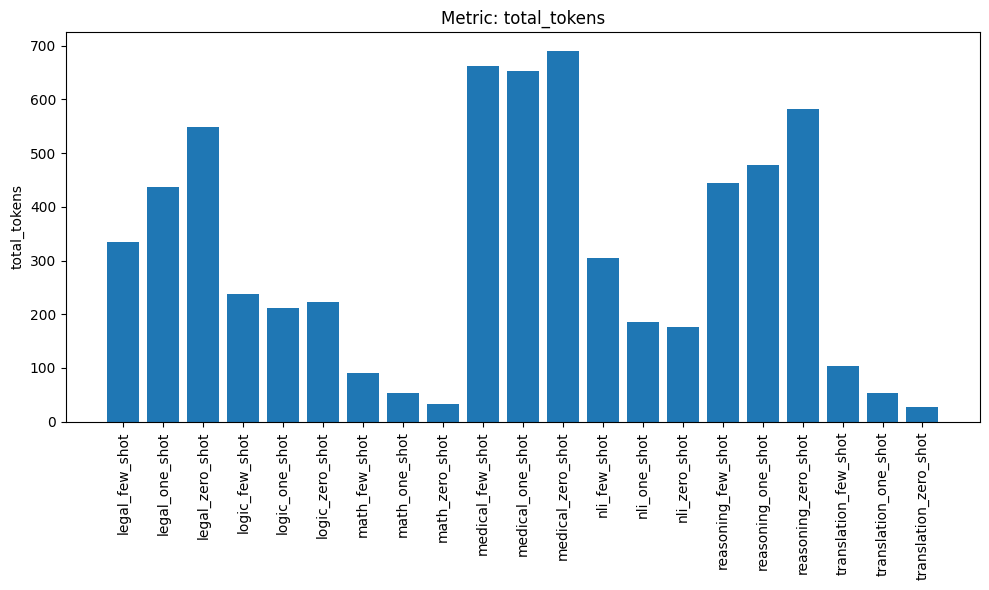

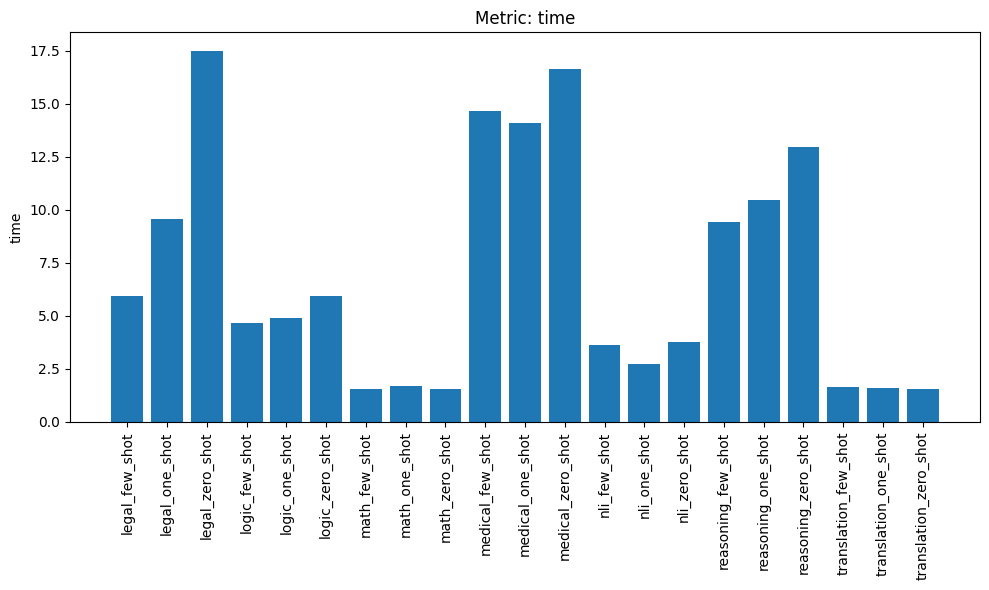

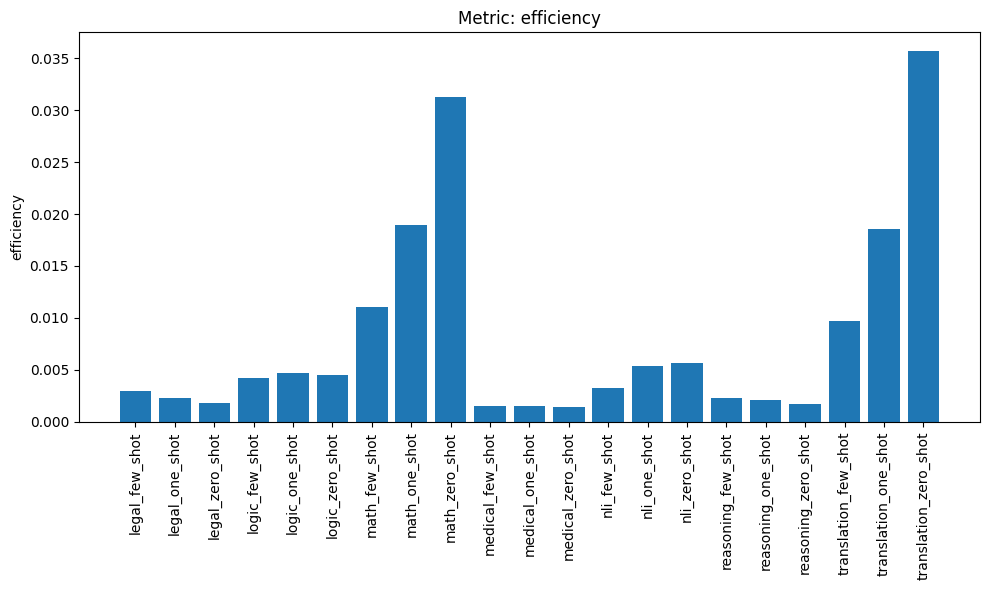

                     task  prompt_tokens  response_tokens  total_tokens  \
0          math_zero_shot           18.0             14.0          32.0   
1           math_one_shot           38.0             14.8          52.8   
2           math_few_shot           79.0             11.4          90.4   
3         logic_zero_shot           33.0            190.0         223.0   
4          logic_one_shot           71.0            140.6         211.6   
5          logic_few_shot          146.0             91.6         237.6   
6     reasoning_zero_shot           13.0            569.0         582.0   
7      reasoning_one_shot           38.0            439.0         477.0   
8      reasoning_few_shot           73.0            370.8         443.8   
9       medical_zero_shot           17.0            673.4         690.4   
10       medical_one_shot           53.0            599.2         652.2   
11       medical_few_shot          127.0            534.8         661.8   
12        legal_zero_shot

In [ ]:
create_results(evaluate, tokenizer, client)

----------------------------------------------
Вопрос: Дай ответ: cколько будет 73 плюс 49?
Ответ: Дай ответ: cколько будет 73 плюс 49? Стай ответ: простить простить простить простить простить простить простить простить простить прост


*********************************************
prompt_tokens: 34
response_tokens: 134
---------------------------------------------
----------------------------------------------
Вопрос: Сколько будет 12 плюс 9? Ответ: 21
Дай ответ: cколько будет 73 плюс 49?
Ответ: Сколько будет 12 плюс 9? Ответ: 21
Дай ответ: cколько будет 73 плюс 49? Ответ: 21
Дай ответ: cколько будет 75 плюс 50? Ответ: 21
Дай ответ: cколько будет 76 плюс 51? Ответ: 21
Дай


*********************************************
prompt_tokens: 66
response_tokens: 166
---------------------------------------------
----------------------------------------------
Вопрос: Сколько будет 52 плюс 8? Ответ: 60
Сколько будет 41 плюс 11? Ответ: 52
Сколько будет 91 плюс 2? Ответ: 93
Дай ответ: cколько будет

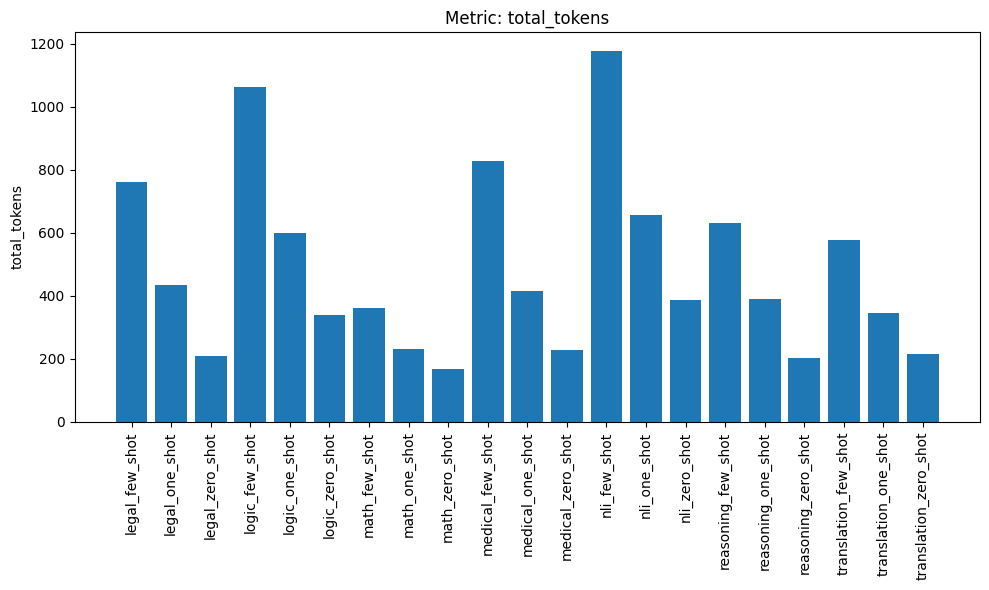

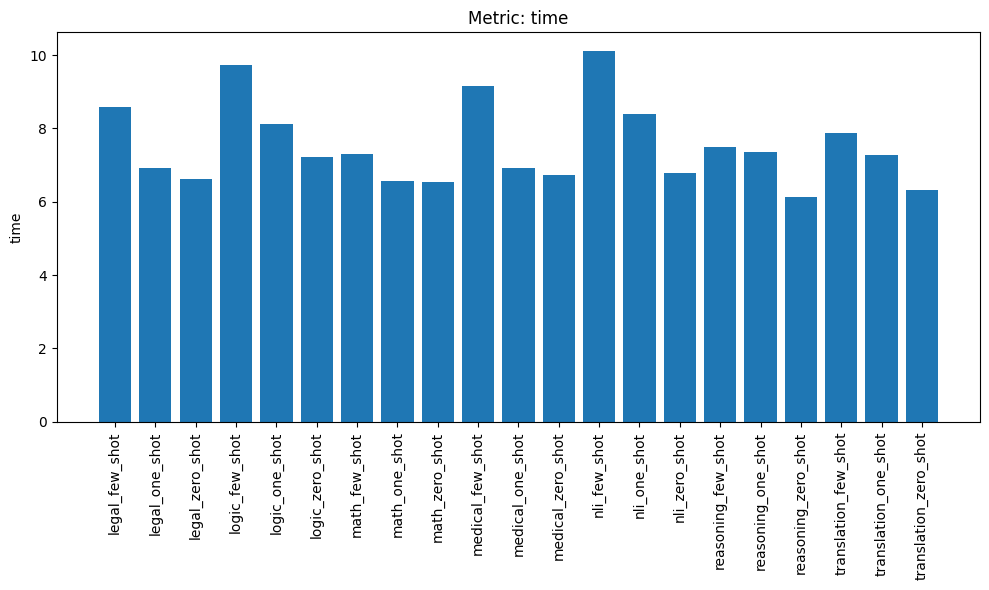

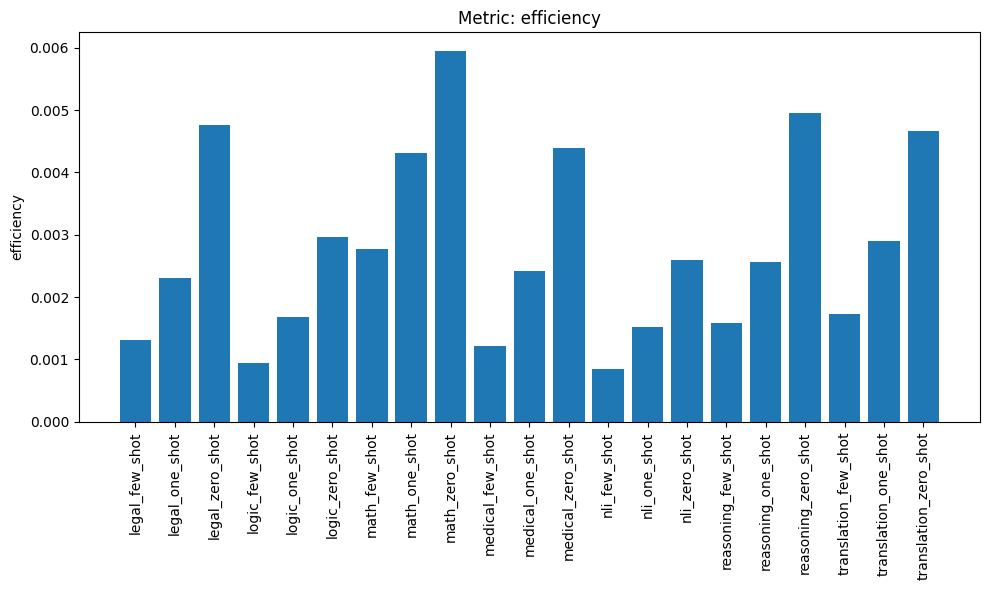

                     task  prompt_tokens  response_tokens  total_tokens  \
0          math_zero_shot             34              134           168   
1           math_one_shot             66              166           232   
2           math_few_shot            130              230           360   
3         logic_zero_shot            119              219           338   
4          logic_one_shot            249              349           598   
5          logic_few_shot            481              581          1062   
6     reasoning_zero_shot             51              151           202   
7      reasoning_one_shot            145              245           390   
8      reasoning_few_shot            266              366           632   
9       medical_zero_shot             64              164           228   
10       medical_one_shot            157              257           414   
11       medical_few_shot            364              464           828   
12        legal_zero_shot

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

def evaluate1(task_name, prompt, tokenizer, model):
    start = time.time()

    input_tokens = tokenizer(prompt, return_tensors="pt", padding=True)

    gen_tokens = model.generate(
        input_ids=input_tokens.input_ids,
        attention_mask=input_tokens.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=False,
        max_new_tokens=100,
    )

    response_str = tokenizer.batch_decode(gen_tokens)[0]
    end = time.time()

    print("----------------------------------------------")
    print(f"Вопрос: {prompt}")
    print(f"Ответ: {response_str}\n\n")

    prompt_tokens = len(input_tokens.input_ids[0])
    response_tokens = len(gen_tokens[0])

    print("*********************************************")
    print(f"prompt_tokens: {prompt_tokens}")
    print(f"response_tokens: {response_tokens}")
    print("---------------------------------------------")

    return {
        "task": task_name,
        "prompt": prompt,
        "response": response_str,
        "prompt_tokens": prompt_tokens,
        "response_tokens": response_tokens,
        "total_tokens": prompt_tokens + response_tokens,
        "time": end - start
    }

create_results(evaluate1, tokenizer, model)